<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S66_driving_DRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
import plotly.express as px

try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

# Deep Reinforcement Learning

> Deep Q-learning and policy gradient.

<img src="Figures6/S66-Autonomous_Vehicle_with_LIDAR_and_cameras-03.jpg" alt="Splash image with steampunk autonomous car" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

Deep reinforcement learning brings the power of deep learning to much more complex domains than what we were able to tackle with the Markov Decision Processes and RL concepts introduced in Chapter 3. The use of large, expressive neural networks has allowed researchers and practitioners alike to work with high bandwidth sensors such as video streams and LIDAR, and bring the promise of RL into real-world domains such as autonomous driving. This is still a field of active discovery and research, however, and we can give but a brief introduction here about what is a vast literature and problem space.

## RL and Autonomous Driving

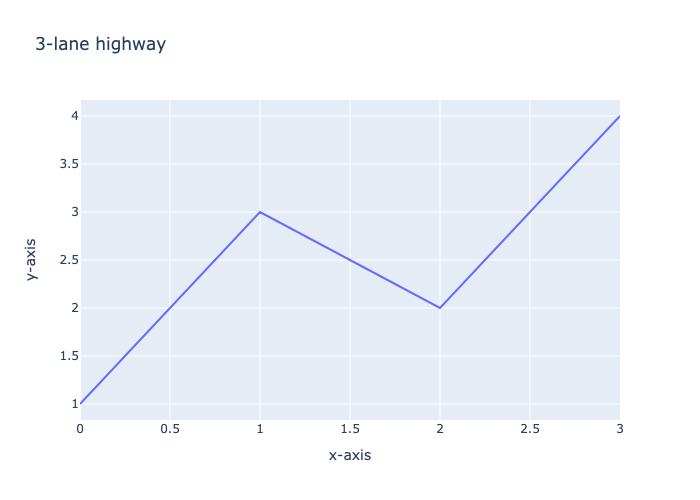

In [3]:
#| caption: A 3-lane highway.
#| label: fig:highway
px.line(x=[0, 1, 2, 3], y=[1, 3, 2, 4], labels={'x': 'x-axis', 'y': 'y-axis'}, title='3-lane highway')

A simple example in the autonomous driving domain is *lane switching*. Suppose we are driving along at 3-lane highway, and we can see some ways ahead, and some ways behind us. We are driving at a speed that is comfortable to us, but other cars have different ideas about the optimal speed to drive at. Hence, sometimes we would like to change lanes, and we could learn a policy to do this for us. This is called **lateral control**. A more sophisticated example would also allow us to adapt our speed to the traffic pattern, but by relying on a smart cruise control system we could safely ignore this **longitudinal control** problem.

To turn this into a reinforcement learning problem, we first need to define a state space ${\cal X}$ and an action space ${\cal A}$. There are a variety of ways to engineer this aspect of the problem. For example, we could somehow encode the longitudinal distance to the lane index for each of the K closest cars, where K is a parameter, say 5 or 10. One problem is that the number of cars that are *actually* present is variable, which is difficult to deal with. Another approach is to make this into an image processing problem, by creating a finite element representation of the road before and behind us, and marking a cell as occupied or not. The latter is fairly compatible with automotive sensors such as LIDAR.

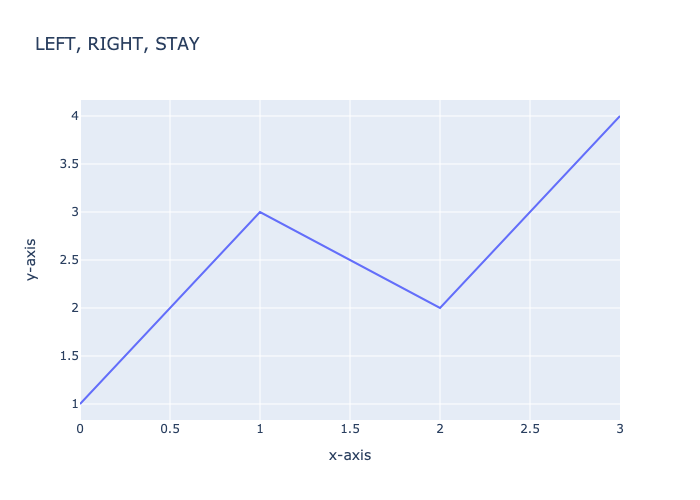

In [4]:
#| caption: Figure with actions LEFT, RIGHT, STAY.
#| label: fig:actions
px.line(x=[0, 1, 2, 3], y=[1, 3, 2, 4], labels={'x': 'x-axis', 'y': 'y-axis'}, title='LEFT, RIGHT, STAY')

In terms of actions, the easiest approach is to have a number of discrete choices to go `left`, `right`, or `stay` in the current lane. We could be more sophisticated about it and have both "aggressive" and "slow" versions of these in addition to a default version, akin to the motion primitives previously discussed.

Actually implementing this on an autonomous vehicle, or even sketching an implementation in a notebook with recorded or simulated data, is beyond what we can accomplish in a notebook. Hence, we will be content below to sketch three popular foundational methods from deep reinforcement learning, without actually implementing them here. At the end of this chapter we provide some references where you can delve into these topics more deeply.

## Deep Q-Learning

> DQN is an early deep learning RL method akin to Q-learning.

Recall from Section 3.6 that we can define a policy in terms of **Q-values**, sometimes also called state-action values, and that we can define the optimal policy as 

$$
\pi^*(x) = \arg \max_a Q^*(x,a)
$$

In Q-learning, we start with some random Q-values and then gradually estimate the optimal Q-values by alpha-blending between old and new estimates:

$$
\hat{Q}(x,a) \leftarrow (1-\alpha) \hat{Q}(x,a) + \alpha~\text{target}(x,a,x')
$$

where $\text{target}(x,a,x') \doteq R(x,a,x') + \gamma \max_{a'} \hat{Q}(x',a')$ is the "target" value that we think is an improvment on the previous value $\hat{Q}(x,a)$.

In the **deep Q-network** or DQN method we use a *supervised learning* approach to Q-learning, by training a neural network, parameterized by $\theta$, to approximate the optimal Q-values:

$$
Q^*(x,a) \approx Q(x,a; \theta)
$$

DQN as a method uses two additional ideas that are crucial in making the training converge to something sensible in difficult problems. The first is splitting the training into *execution* and *experience replay* phases:

- during the **execution phase**, it executes the policy (possibly with some degree of randomness) and stores the experiences $(x,a,r,x')$, with $r$ the reward, in a dataset $D$;
- during **experience replay**, it *randomly samples* from these experiences to create mini-batches of data, which are in turn used to perform stochastic gradient descent on the parameters $\theta$.

The second is to calculate the target values $\text{target}(x,a,x') \doteq R(x,a,x') + \gamma \max_{a'} \hat{Q}(x',a'; \theta^{old})$ with the parameters $\theta^{old}$ from the previous epoch, to provide a more stable approximation target.

With this basic scheme, a team from DeepMind was able to achieve human or super-human performance on about 50 Atari 2600 games in 2015 (Minh et al., Nature 2015, Vol. 518).

## Policy Optimization

> Policy optimization takes a black box optimization approach to a deep policy.

We can use a deep neural network, parameterized by $\theta$, to encode a **stochastic policy**:

$$
\pi(a|x, \theta)
$$

where $a \in {\cal A}$ is an action, $x \in {\cal X}$ is a state, and the policy outputs a *probability* for each action $a$ based on the state $x$.

Similar to policy iteration, policy optimization tries to find the policy $\pi$ that maximizes the expected utility. One way to estimate this quantity is to do a rollout for a finite horizon $H$, as we discussed in Chapter 3. An often used loss function when stochastic policy parameters $\theta$ being optimized for is

$$
\mathcal{L}(\theta) = \sum_{t=0}^H R^t - \log \pi(a_t|x_t, \theta)
$$

where $R^t$ is the expected return for the $t^{th}$ transition in the rollout, and is computed as

$$
R^t \doteq \sum_{k=t}^H \gamma^{k-t}R(x_t,a_t,x_{t+1})
$$

The reason to use $\log \pi(a_t|x_t, \theta)$

A very simple optimization method is **hill climbing**:

- initialize $\theta$ and compute $\mathcal{L}(\theta)$.
- until convergence:
    - perturb $\theta$ to $\theta'$
    - if $\mathcal{L}(\theta') < \mathcal{L}(\theta)$:
        - set $\theta \leftarrow \theta'$

Above the *perturbation* step could be as simple as adding some Gaussian noise to the weights of the network.

More sophisticated "black-box" approaches such as genetic algorithms or evolution strategies can be applied to this problem instead, but they all share the property that they are "gradient-free", which seems to be a sub-optimal strategy. Hence, we next look at a gradient descent approach to policy optimization.

## Policy Gradient

> Policy gradient methods are akin to policy iteration, with a deep twist.

In a nutshell, policy gradient calculates the gradient of the loss with respect to the policy parameters $\theta$:

$$
\nabla_\theta \mathcal{L}(\theta) \leftarrow \sum_{t=0}^H - R_t \nabla_\theta \log \pi(a_t|x_t, \theta)
$$

and then uses gradient descent to update the policy parameters:

$$
\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}(\theta)
$$

where $\alpha$ is a learning rate.

There are a whole host of reasons why the above, vanilla **policy gradient algorithm**, does not work well. Hence, there is a large variety of methods that try to improve the performance of this algorithm, beginning with the 1992 REINFORCE method (Williams, 1992), up to more modern methods such as PPO, which is now one of the most often-used methods.
